<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/explore_data_dtc_2_curate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring HTR3A protein target activity data from Drug Target Commons

The Target specific data was downloaded from https://drugtargetcommons.fimm.fi/

Please refer to the ExCAPE-DB publication (https://pubmed.ncbi.nlm.nih.gov/29276046/) for details about the database 

Here are some details about HTR3A gene (taken from RefSeq NCBI)
*The product of this gene belongs to the ligand-gated ion channel receptor superfamily. This gene encodes subunit A of the type 3 receptor for 5-hydroxytryptamine (serotonin), a biogenic hormone that functions as a neurotransmitter, a hormone, and a mitogen. This receptor causes fast, depolarizing responses in neurons after activation. It appears that the heteromeric combination of A and B subunits is necessary to provide the full functional features of this receptor, since either subunit alone results in receptors with very low conductance and response amplitude. Alternatively spliced transcript variants encoding different isoforms have been identified.*

Diseases associated with HTR3A include Irritable Bowel Syndrome and Motion Sickness.

## Basic information about HTR3A gene:

**Present in** Chromosome 11
**Exon count:** 10

mRNA and protein information

*   NM_000869.6 → NP_000860.3 
*   NM_001161772.3 → NP_001155244.1
*   NM_213621.4 → NP_998786.3 








# Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings

## Plesae change your runtime settings to use GPU and high-memory, if you have 

## Runtime --> Change Runtime Type --> GPU wityh high-RAM

In [ ]:
!date # starting time

Tue Feb 16 02:24:11 UTC 2021


## Install AMPL GPU version

```
real	2m59.739s
user	1m48.995s
sys	0m20.614s
```

In [ ]:
import requests

# Copy AMPL install script
url='https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU.sh'

downloaded_obj = requests.get(url)
with open("install_AMPL_GPU.sh", "wb") as file:
    file.write(downloaded_obj.content)


# Install and load AMPL
!chmod u+x install_AMPL_GPU.sh
!time ./install_AMPL_GPU.sh
import sys
if '/content/AMPL/lib/python3.6/site-packages' not in sys.path:
    sys.path.insert(1, '/content/AMPL/lib/python3.6/site-packages')

sys.path

--2021-02-16 02:24:12--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94235922 (90M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  89.87M   241MB/s    in 0.4s    

2021-02-16 02:24:13 (241 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [94235922/94235922]

PREFIX=/content/AMPL
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /content/AMPL

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - brotlipy==0.7.0=py38h27cfd23_1003
    - ca-certificates==2020.10.14=0
    - certifi==2020.6.20=pyhd3eb1b0_3
    - cffi==1.14.3=py38h261ae71_2
    - chardet==3.0.4=py38h06a4308_1003
    - conda-package-han

['',
 '/content/AMPL/lib/python3.6/site-packages',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

## Exploring target activity data from selected database
## Data source = ExcapeDB
## Target activity for the receptor HTR3A

In [ ]:
# There is a problem with the previously imported cffi, so delete it and 
# load it with AMPL instead
if 'cffi' in sys.modules:
  del sys.modules['cffi']

In [ ]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

In [ ]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

/content/AMPL/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Select a target to work with 
### (e.g. PDE2A, KCNH2, SCNA5)

In [ ]:
target_name='HTR3A'

# Define data locations 

In [ ]:
# ofile=target_name+'_excape_curated.csv'
ofile=target_name+'_dtc_smiles.csv'

## Note the file `HTR3A_dtc_smiles.csv` was the output from https://github.com/ravichas/AMPL-Tutorial/blob/master/explore_data_dtc_min_viable_one.ipynb notebook

In [ ]:
import io
url = 'https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/HTR3A_dtc_smiles.csv'
download = requests.get(url).content

In [ ]:
# Reading the downloaded content and turning it into a pandas dataframe
save_smiles_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

In [ ]:
# save_smiles_df.rename( columns={ "PIC50" : "PXC50" }, inplace=True) 

##Check for assay replicates with high measurement variation and flag them 

In [ ]:
import os

# From our dataframe, we are working with the PIC50 column 
data=save_smiles_df

# Here we are defining our response column, which will be PIC50
column = 'PIC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'standard_inchi_key'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# Here we are creating a new dataframe, called check_df
check_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (197, 52)
List of 'bad' duplicates removed
              standard_inchi_key     PIC50  ...   Perc_Var  VALUE_NUM_std
172  FZGWDCDUMFWUEO-UHFFFAOYSA-N  8.159894  ...  11.975455       1.234152
173  FZGWDCDUMFWUEO-UHFFFAOYSA-N  6.414539  ...  11.975455       1.234152
67   KQKPFRSPSRPDEB-UHFFFAOYSA-N  5.000000  ...  23.262963       2.143606
68   KQKPFRSPSRPDEB-UHFFFAOYSA-N  8.031517  ...  23.262963       2.143606

[4 rows x 5 columns]

Dataset de-duplicated
Dataframe size (170, 52)
New column created with averaged values:  VALUE_NUM_mean


## Examine the rejected compounds and examine them

In [ ]:
old_compound_id='rdkit_smiles'
new_compound_id='rdkit_smiles'

# Takes all the compounds that aren't part of the curated data frame and prints them
reject=data[~data[old_compound_id].isin(check_df[new_compound_id])]
reject

,compound_id,uniprot_id,compound_name,standard_inchi_key,max_phase,target_pref_name,gene_names,target_class,wildtype_or_mutant,mutation_information,pubmed_id,standard_type,standard_relation,standard_value,standard_units,mode_of_action,assay_format,assay_type,assay_sub_type,inhibitor_type,detection_technology,compound_concentration_value,compound_concentration_value_units,substrate_type,substrate_type_standard_relation,substrate_type_standard_value,substrate_type_standard_units,assay_cell_line,assay_description,activity_comments,title,journal,year,volume,issue,authors,annotation_comments,assay_id,dtc_tid,dtc_activity_id,dtc_molregno,record_id,dtc_document_id,PIC50,Unnamed: 0,CID,smiles,rdkit_smiles
67,CHEMBL128,P46098,SUMATRIPTAN,KQKPFRSPSRPDEB-UHFFFAOYSA-N,4,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,7752204.0,IC50,>,10000.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Binding activity radioligand.,NaN,"Synthesis and serotonergic activity of N,N-dim...",J. Med. Chem.,1995.0,38.0,10.0,"Street LJ, Baker R, Davey WB, Guiblin AR, Jell...",NaN,3126.0,DTCT0023221,520894,DTCC00154636,658692,13017,5.000000,110,5358,CNS(=O)(=O)CC1=CC2=C(C=C1)NC=C2CCN(C)C,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1
68,CHEMBL128,P46098,SUMATRIPTAN,KQKPFRSPSRPDEB-UHFFFAOYSA-N,4,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,9357515.0,IC50,=,9.30,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Compound was evaluated for the affinity at 5-h...,NaN,"Selective, orally active 5-HT1D receptor agoni...",J. Med. Chem.,1997.0,40.0,22.0,"MacLeod AM, Street LJ, Reeve AJ, Jelley RA, St...",NaN,3459.0,DTCT0023221,712596,DTCC00154636,659675,14385,8.031517,110,5358,CNS(=O)(=O)CC1=CC2=C(C=C1)NC=C2CCN(C)C,CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1
172,CHEMBL470432,P46098,NaN,FZGWDCDUMFWUEO-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,19261477.0,IC50,=,6.92,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Displacement of [3H]granisetron from human rec...,NaN,Novel antagonists of serotonin-4 receptors: sy...,Bioorg. Med. Chem.,2009.0,17.0,6.0,"Lemaître S, Lepailleur A, Bureau R, Butt-Gueul...",NaN,564583.0,DTCT0023221,2613037,DTCC00570224,1082935,33265,8.159894,723,42636941,CCCN1CCC(CC1)COC2=NC3=C(C(=CS3)C)N4C2=CC=C4,CCCN1CCC(COc2nc3scc(C)c3n3cccc23)CC1
173,CHEMBL470432,P46098,NaN,FZGWDCDUMFWUEO-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,19261477.0,IC50,=,385.00,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NG108-15,Antagonist activity at 5HT3 receptor in hybrid...,NaN,Novel antagonists of serotonin-4 receptors: sy...,Bioorg. Med. Chem.,2009.0,17.0,6.0,"Lemaître S, Lepailleur A, Bureau R, Butt-Gueul...",NaN,564575.0,DTCT0023221,2613019,DTCC00570224,1082935,33265,6.414539,723,42636941,CCCN1CCC(CC1)COC2=NC3=C(C(=CS3)C)N4C2=CC=C4,CCCN1CCC(COc2nc3scc(C)c3n3cccc23)CC1


In [ ]:
# Prints number of unique rejected compound names and rows
print("Number of discarded compounds",reject[compound_id].nunique())

# Apecifies directory for csv file to send rejected data to, saving it as ofile 
ofile = target_name+'.reject_check'

# Sends the rejected compound dataframe to a csv file with the path (ofile) specified above
reject.to_csv(ofile,index=False)

Number of discarded compounds 2


In [ ]:
# Prints all the results of the unique assay tests run on this target
save_smiles_df['assay_description'].unique()

array(['Inhibitory concentration required against 5-HT3 receptor in bovine area postrema using [3H]GR-65630',
       'Binding affinity to human recombinant serotonin 5HT3 receptor',
       'Agonist activity at human 5HT3A receptor expressed in HEK293 cells by FLIPR assay',
       'Displacement of [3H]granisetron from human recombinant 5-HT3 receptor expressed in HEK293 cells',
       nan,
       'Antagonist activity at human wild type 5-HT3A receptor expressed in HEK293 cells assessed as inhibition of 5-HT-induced response after 45 mins by FLIPR assay',
       'Compound was tested for its affinity towards 5-hydroxytryptamine 3 receptor',
       'Displacement of [3H]BRL 43694 from human recombinant 5HT3 receptor expressed in CHO cells',
       'Antagonist activity at human 5HT3 receptor',
       'Displacement of [3H]BRL-43694 from human 5HT3 receptor expressed in HEK293 cells by liquid scintillation counting',
       'Displacement of [3H]BRL-43694 from human recombinant 5HT3 receptor',


In [ ]:
# Collects all the non-rejected data into a new frame called data
data=save_smiles_df[~save_smiles_df[compound_id].isin(reject[compound_id])]

# Prints the rows & columns (in that order) of the dataset from above (i.e. all the matching data)
# Shape is an array that can check how large the dataframe is 
# It will print out (x, y), the x is the rows, or lines, and y is the number of columns 
print(data.shape)

(197, 48)


In [ ]:
data[['standard_inchi_key','rdkit_smiles','standard_relation']].head(5)

,standard_inchi_key,rdkit_smiles,standard_relation
0,OSVMSQACZRYAPT-UHFFFAOYSA-N,COc1cccc(CN2CCN(C3CCC(O)(c4ccc5c(c4)OCO5)CC3)C...,>
1,CKLPLPZSUQEDRT-WPCRTTGESA-N,CC1Cc2c([nH]c3cc(Cl)c(F)cc23)C2(N1)C(=O)Nc1ccc...,>
2,YOCUJVXRRWEPDN-UHFFFAOYSA-N,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccccc2F)nc1,>
3,LMGUUVWYFJIKCD-UHFFFAOYSA-N,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccc(F)cc2)nc1,>
4,DFBQTBNRGSIKHN-UHFFFAOYSA-N,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccc(F)nc2)nc1,>


In [ ]:
#specifies the column we want (response value) and also tells it to include the duplicates
column='PIC50'; #'standard_value'
list_bad_duplicates='Yes'

# Actually compiles all the data with the specifies column and tells what columns to include 
# (inchi_key, smiles, and relation)
temp_df=curate_data.aggregate_assay_data(data, 
                                         value_col=column, 
                                         output_value_col=None,
                                         label_actives=True,
                                         active_thresh=6,
                                         id_col='standard_inchi_key', 
                                         smiles_col='rdkit_smiles', 
                                         relation_col='standard_relation')

#Removes all duplicates from the data frame and puts it in the final, curated dataframe
curated_df = temp_df[~temp_df.isin([np.inf]).any(1)]

0 entries in input table are missing SMILES strings
170 unique SMILES strings are reduced to 170 unique base SMILES strings


## Save data to a file

In [ ]:
# prints the number of rows in the before and after curation 
print("before",data.shape[0],"after",curated_df.shape[0])

#prints the first few rows of the "after" (after curation) dataframes
curated_df.head()

before 197 after 170


,compound_id,base_rdkit_smiles,relation,PIC50,active
0,WLYLIKBNGQZDFH-UHFFFAOYSA-N,O=C(NCCCN1CCOCC1)c1ccc2c(=O)n(Cc3ccc(Cl)cc3)c(...,,5.886057,0
1,PNHTUMMCJLWVTR-UHFFFAOYSA-N,COc1ccc(-c2cc(NC(=O)CCCCN3CCCOCC3)n[nH]2)cc1,>,4.522879,0
2,PYCJRTFNOGPLEL-UHFFFAOYSA-N,Nn1c(CCCCN2CCN(c3ccc4ccccc4n3)CC2)nc2cc(Cl)ccc...,>,7.000000,1
3,MMIPHEFKLSFNNB-MWGLOKQDSA-L,COc1ccc(C[N+]23CCC4C5C6C(CC42)C(=CCOC6N2c4cccc...,,4.511439,0
4,PWVBQEUMVVPFJT-UHFFFAOYSA-N,Nn1c(CCCCN2CCN(c3ccc4ccccc4n3)CC2)nc2cc(F)ccc2...,>,7.000000,1


In [ ]:
# Prints number of unique resjected compound names/rows
print("Number of discarded compounds",reject[compound_id].nunique())

# Apecifies directory for csv file to send rejected data to, saving it as ofile 
ofile=tmp_dir+target_name+'.reject_check.'+username

# Sends the rejected compound dataframe to a csv file with the path (ofile) specified above
reject.to_csv(ofile,index=False)

In [ ]:
# specifies file path to save the curated data to
ofile = target_name+'_dtc_smiles_curated.csv'

# sends data from the curated_df to csv with specified path above
curated_df.to_csv(ofile,index=False)

(0.0, 12.0)

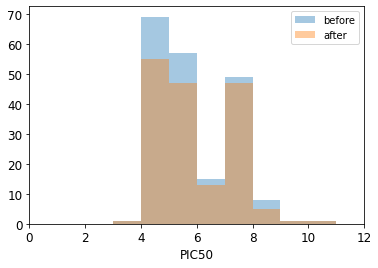

In [ ]:
# load graphics libraries matplotlib and seaborn (sns)
import matplotlib.pyplot as plt
import seaborn as sns

# plt.subplots is a function that creates a full grid of subplots in a single array, and returning 
# them in a NumPy array
# A NumPy array is a grid of values, all of the same type, and is indexed by a tubule of nonnegative integers 
# We are saving this subplots we're creating as fig, ax variables
fig, ax = plt.subplots()

# compiles the data frames before and after all the curation with the specified column value (response values)
# If we remember or look up further in the notebook, we created two dataframes: data and curated_df 
# Our data dataframe consists of ofile (target_name+'_excape_curated.csv.'+username) and we will be using the PIC50 column of our dataframe
# This will be our before variable
before=save_smiles_df["PIC50"]

# Our after variable is comprised of our curated_df dataframe 
# Our curated_df was configured earlier to discard any out of range values
after=curated_df["PIC50"]

# plots the values of the response value column of both the before and after dataframes from above
# sns.distplot is a Seaborn distplot, which allows you to show a histogram with a line on it
# A distplot plots a univariate distribution of observations 
# Below, we are separating our data set into a before section and an after section 
# To break down the sns.distplot functions: 
# bins=range(0, 12, 1) is used to bin our range of values, meaning to divide the entire range of values into a series of intervals
# ax=ax 
# kde is a kernel density estimate plot that represents the data using a continuous probability density curve
# kde=False will remove the density line on the histogram
# The label= function is used to label different sections of our plot 
sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')

#configures plot by adding a legend and setting the x axis limits for readability
# plt.legend() adds the legend to the plot
plt.legend()

# ax.set_xlim is setting the x-axis limits of the graph, setting it to be from (0,12)
ax.set_xlim([0, 12])


In [ ]:
!date # ending time

Fri Feb 12 20:53:04 UTC 2021
